Qconfig loaded from C:\Users\ddrsq\OneDrive\Quantum\quantum_rb\Qconfig.py.
Available backends:  ['local_statevector_simulator', 'local_unitary_simulator', 'ibmq_qasm_simulator', 'local_qasm_simulator', 'ibmqx5', 'local_clifford_simulator', 'ibmqx2', 'ibmqx4']
ibmqx5
[[1, 0], [1, 2], [2, 3], [3, 4], [3, 14], [5, 4], [6, 5], [6, 7], [6, 11], [7, 10], [8, 7], [9, 8], [9, 10], [11, 10], [12, 5], [12, 11], [12, 13], [13, 4], [13, 14], [15, 0], [15, 2], [15, 14]]
2
got
here
nice
{'00': 676, '01': 124, '10': 114, '11': 110}


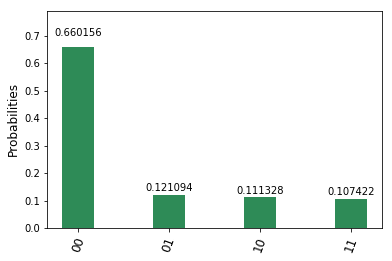

got
here
nice
{'00': 608, '01': 161, '10': 146, '11': 109}


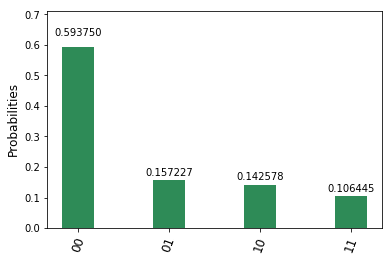

got
here


In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError
from qiskit import available_backends, register, execute, get_backend
from qiskit.tools.visualization import circuit_drawer, plot_histogram, plot_state
from qiskit.tools.qi.qi import state_fidelity
import random
import pickle
import time

# helpful function
state_overlap = lambda state1, state2: np.absolute(np.dot(state1.conj().T,state2))**2

#setup
import sys, getpass
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
    print('Qconfig loaded from %s.' % Qconfig.__file__)
except:
    APItoken = getpass.getpass('Please input your token and hit enter: ')
    qx_config = {
        "APItoken": APItoken,
        "url":"https://quantumexperience.ng.bluemix.net/api"}
    print('Qconfig.py not found in qiskit-tutorial directory; Qconfig loaded using user input.')
    
#matlab stuff
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import matrix
from math import pi

#set api token 
QX_TOKEN = "96c86855a5c381875a4ea3a956a7deafbbbbb82e5912ec73655c7c444d2597a7364eda2fa558e4e37f672640029443216899825f945d5a0684e31b796837ce61"
QX_URL = "https://quantumexperience.ng.bluemix.net/api"


#register token and url
register(QX_TOKEN, QX_URL)


# for getting a backend
def lowest_pending_jobs():
    """Returns the backend with lowest pending jobs."""
    list_of_backends = available_backends(
        {'local': False, 'simulator': False})
    device_status = [get_backend(backend).status
                     for backend in list_of_backends]

    best = min([x for x in device_status if x['available'] is True],
               key=lambda x: x['pending_jobs'])
    return best['name']

# query for available backends
print("Available backends: ", available_backends())

device_name = lowest_pending_jobs()
device = get_backend(device_name)
device_coupling = device.configuration['coupling_map']
print(device)
print(device_coupling)


backend = 'ibmqx5'

# adds dictionaries
def tally(counts, toAdd):
    for key in toAdd:
        if key not in counts.keys():
            counts[key]=0
        counts[key] = counts[key] + toAdd[key]
    return counts

# add phase gate 
def addPhase(qc):
    qc.h(qr[0])
    qc.h(qr[1])
#    qc.swap(qr[0],qr[1])
    qc.s(qr[0])    
    
# remove phase gate
def removePhase(qc):
    qc.sdg(qr[0])
#    qc.swap(qr[0],qr[1])
    qc.h(qr[1])
    qc.h(qr[0])

# compile into different states
def compilation(qc,i):
        if i == 0: 
            qc.iden(qr[0])
            qc.iden(qr[1])
        elif i == 1:
            qc.x(qr[0])
            qc.iden(qr[1])
        elif i == 2:
            qc.iden(qr[0])
            qc.x(qr[1])
        elif i == 3:
            qc.x(qr[0])
            qc.x(qr[1])
            
            
# parse a string of gens
def addCliffGens(qc, string):
    for char in string:
        i = int(char)
        if i==0:
            qc.x(qr[0])
        elif i==1:
            qc.x(qr[1])
        elif i==2:
            qc.z(qr[0])
        elif i==3:
            qc.z(qr[1])
        elif i ==4:
            qc.h(qr[0])
            qc.h(qr[1])
            qc.swap(qr[0],qr[1])
        elif i == 5:
            qc.cz(qr[0],qr[1])
            qc.z(qr[0])
            qc.z(qr[1])
        elif i==6:
            qc.cx(qr[0],qr[1])
        elif i==7:
            qc.cx(qr[1],qr[0])
            
# search dictionary for key corresponding to matrix
def findGenString(mat):
    for key, value in r2group.items():
        if np.array_equal(value, mat):
            return key
    print("OH NO")
    return None
        
# invert cliff gens
def invertCliffGens(qc, mat):
    genString = findGenString(mat)
    for char in genString[::-1]:
        i = int(char)
        if i==0:
            qc.x(qr[0])
        elif i==1:
            qc.x(qr[1])
        elif i==2:
            qc.z(qr[0])
        elif i==3:
            qc.z(qr[1])
        elif i ==4:
            qc.swap(qr[0],qr[1])
            qc.h(qr[0])
            qc.h(qr[1])
        elif i == 5:
            qc.z(qr[0])
            qc.z(qr[1])
            qc.cz(qr[0],qr[1])
        elif i==6:
            qc.cx(qr[0],qr[1])
        elif i==7:
            qc.cx(qr[1],qr[0])

# add a random real clifford            
def addRandCliff(qc, mat):
    genString = random.choice(list(r2group.keys()))
    addCliffGens(qc,genString)
    qc.barrier(qr)
    return np.matmul(mat,r2group[genString])

# fidelity test 
def desiredStates(compiledstates):
    if compiledstates == 0:
            return np.array((1,0,1,0))
    elif compiledstates == 1:
            return np.array((0,1,1,0))
    elif compiledstates == 2:
            return np.array((1,0,0,1))
    elif compiledstates == 3:
            return np.array((0,1,0,1))
        
def fidelityTest(statevector,desiredvector):
    fidelity = state_fidelity(statevector, desiredvector)
    return fidelity


pickle_in = open("r2group.pickle", "rb")
r2group = pickle.load(pickle_in)


trials = 1
reps = 9
initialStates = 4
shots = 1024


startTime = time.time()

for k in range(initialStates):

    for i in range(trials):
        length = 2+3*i
        print(length)
        counts = {}

        # run our trials
        for i in range(reps):

            # run one trial of given length 
            mat = r2group[""]
            n = 2
            qr = QuantumRegister(n)
            cr = ClassicalRegister(n)
            qc = QuantumCircuit(qr, cr)

            # optional: add phase
            addPhase(qc)

            # add the first m-1 clifford gates
            for i in range(length):
                mat = addRandCliff(qc,mat)

            # invert everything
            invertCliffGens(qc,mat)
            
            # optional: remove phase
            removePhase(qc)

            # get the qc compiled into one of the 4 different states
            compilation(qc,k)
            
            # measure
            qc.measure(qr,cr)
            
            print("got")
            job = execute(qc, backend, shots = shots)
            print("here")
            result = job.result()
            print("nice")
            
            print(result.get_counts(qc))

            plot_histogram(result.get_counts(qc))
    
endTime = time.time()
print("Time elapsed: ", endTime-startTime)
    

 
    
    